In [1]:
import osmnx as ox
import networkx as nx
import pandas as pd
import numpy as np
import geopandas as gpd

import matplotlib.pyplot as plt

In [2]:
%time G = ox.graph_from_place('Bangladesh', network_type='drive')

CPU times: user 13min 46s, sys: 14.8 s, total: 14min 1s
Wall time: 14min 2s


In [3]:
N, E = ox.graph_to_gdfs(G)

N = N.to_crs(3857)
E = E.to_crs(3857)

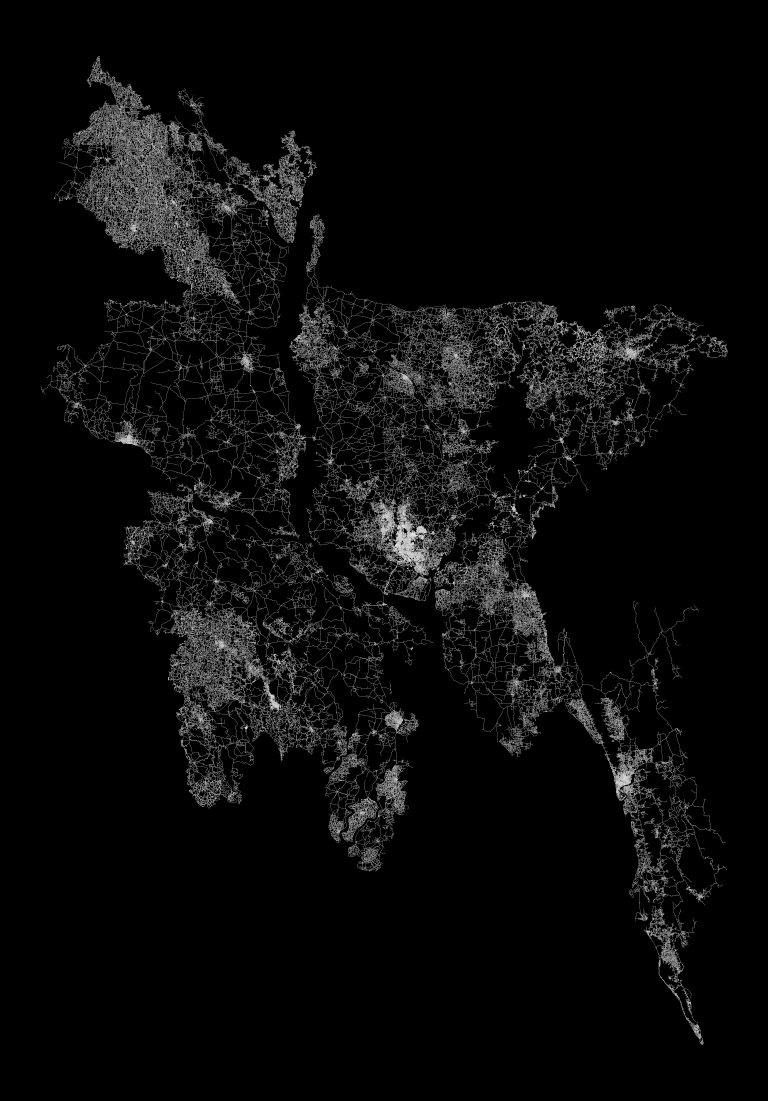

In [4]:
fig, ax = plt.subplots(1, 1, figsize = (20, 20), facecolor = 'k')

E.plot(color='w', ax=ax, linewidth=0.1)
ax.set_axis_off()
ax.set_facecolor('k')

In [5]:
E[ox.io._stringify_nonnumeric_cols(E).name.str.contains("বঙ্গবন্ধু সেতু")].explore()

In [6]:
E[ox.io._stringify_nonnumeric_cols(E).name.str.contains("পদ্মা সেতু")].explore()

In [7]:
dhaka = ox.geocoder.geocode("Dhaka, Bangladesh")
dhaka = ox.distance.nearest_nodes(G, dhaka[1], dhaka[0], return_dist=False)

In [8]:
from colorcet import palette
from matplotlib import colors

col = colors.LinearSegmentedColormap.from_list("bmw", palette['bmw'][::-1])

In [9]:
jamuna = E[ox.io._stringify_nonnumeric_cols(E).name.str.contains("বঙ্গবন্ধু সেতু")].reset_index()
padma = E[ox.io._stringify_nonnumeric_cols(E).name.str.contains("পদ্মা সেতু")].reset_index()

In [10]:
aoi_j = gpd.GeoDataFrame(geometry=gpd.GeoSeries(jamuna.geometry.unary_union.buffer(10000).envelope), crs=3857)
aoi_p = gpd.GeoDataFrame(geometry=gpd.GeoSeries(padma.geometry.unary_union.buffer(10000).envelope), crs=3857)

In [11]:
def cut_bridge(graph, bridge):
    
    graph = graph.copy()
    for i, r in bridge.iterrows():
        graph.remove_edge(r['u'], r['v'])
        
    return graph

In [12]:
# no jamuna
G_pre = cut_bridge(G, jamuna)

# no padma
G_pre = cut_bridge(G_pre, padma)

In [13]:
N_pre, E_pre = ox.graph_to_gdfs(G_pre)

E_pre = E_pre.to_crs(3857)
N_pre = N_pre.to_crs(3857)

In [14]:
%time pre_isolines = nx.single_source_dijkstra(G_pre, dhaka, weight='length')

CPU times: user 2.14 s, sys: 154 ms, total: 2.29 s
Wall time: 2.29 s


In [15]:
 pre_distances = pd.DataFrame({'osmid': pre_isolines[0].keys(), 'distance': pre_isolines[0].values()})

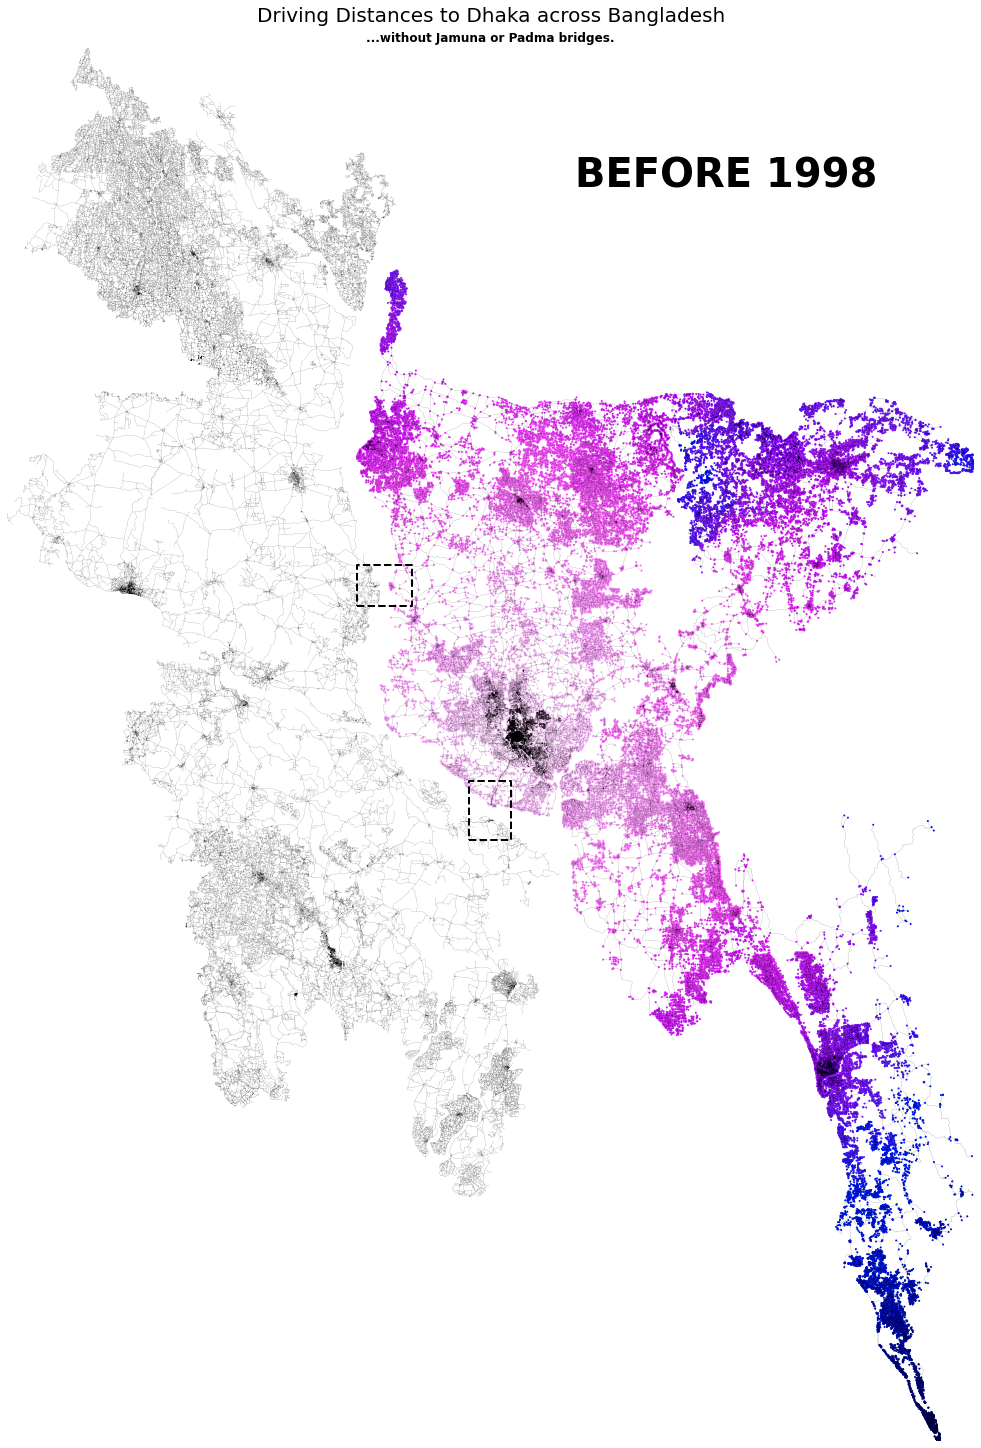

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20), 
                       facecolor='w',
                       constrained_layout=True, 
                       subplot_kw=dict(aspect='equal'))

E_pre.plot(color='k', linewidth=0.05, ax=ax)

N_pre.merge(pre_distances, 
            left_on='osmid', 
            right_on='osmid', 
            how='left').to_crs(3857).plot('distance', markersize=1, cmap=col, ax=ax,
                                         vmin=pre_distances.distance.min(),
                                         vmax=pre_distances.distance.max())

aoi_j.boundary.plot(color='k', linestyle='dashed', linewidth=2, ax=ax)
aoi_p.boundary.plot(color='k', linestyle='dashed', linewidth=2, ax=ax)

N[N.index==dhaka].plot(color='k', markersize=1000, ax=ax)

ax.text(0.9, 0.9,
        "BEFORE 1998",
        color="k",
        weight='bold',
        fontsize=40,
        ha="right",
        transform=ax.transAxes,
       )


ax.set_xlim((N.geometry.x.min(), N.geometry.x.max()))
ax.set_ylim((N.geometry.y.min(), N.geometry.y.max()))

ax.set_title("...without Jamuna or Padma bridges.", color='k', weight='bold')

ax.set_axis_off()

fig.suptitle("Driving Distances to Dhaka across Bangladesh", fontsize=20, color='k')
fig.savefig('./scenarios/bangladesh-1.png', facecolor=fig.get_facecolor(), dpi=300, bbox_inches='tight')

In [34]:
# no padma
G_mid = cut_bridge(G, padma)

In [35]:
N_mid, E_mid = ox.graph_to_gdfs(G_mid)

E_mid = E_mid.to_crs(3857)
N_mid = N_mid.to_crs(3857)

In [36]:
%time mid_isolines = nx.single_source_dijkstra(G_mid, dhaka, weight='length')

CPU times: user 5.08 s, sys: 432 ms, total: 5.51 s
Wall time: 5.51 s


In [37]:
 mid_distances = pd.DataFrame({'osmid': mid_isolines[0].keys(), 'distance': mid_isolines[0].values()})

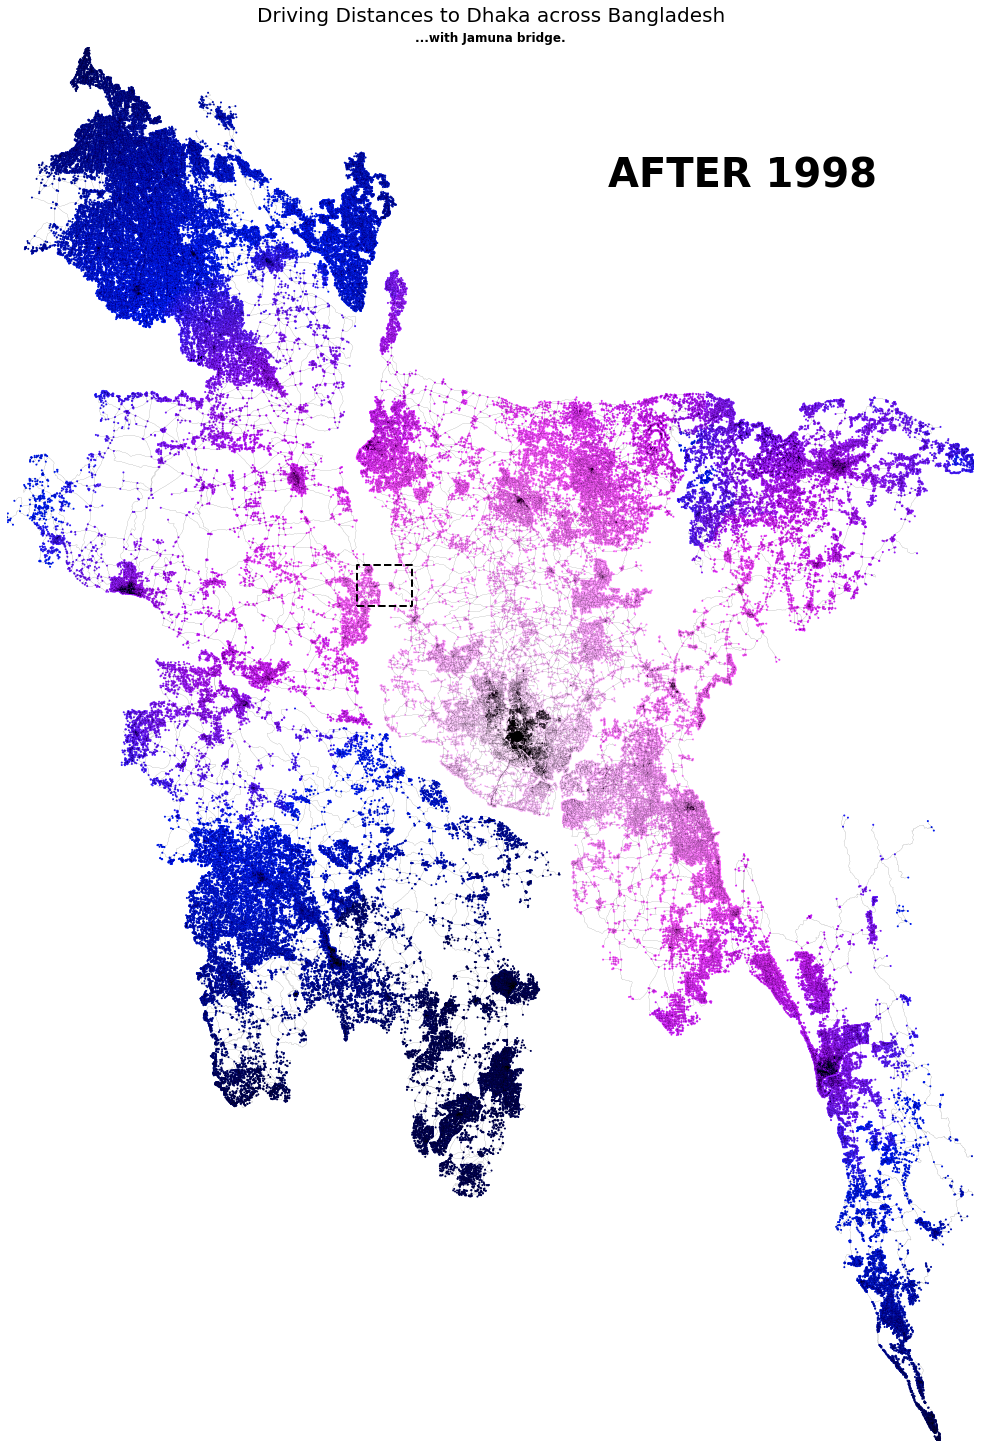

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20), 
                       facecolor='w',                       
                       constrained_layout=True, 
                       subplot_kw=dict(aspect='equal'))

E_mid.plot(color='k', linewidth=0.05, ax=ax)

N_mid.merge(mid_distances, 
            left_on='osmid', 
            right_on='osmid', 
            how='left').to_crs(3857).plot('distance', markersize=1, cmap=col, ax=ax,
                                         vmin=pre_distances.distance.min(),
                                         vmax=pre_distances.distance.max())

aoi_j.boundary.plot(color='k', linestyle='dashed', linewidth=2, ax=ax)

N[N.index==dhaka].plot(color='k', markersize=1000, ax=ax)

ax.text(0.9, 0.9,
        "AFTER 1998",
        color="k",
        weight='bold',
        fontsize=40,
        ha="right",
        transform=ax.transAxes,
       )

ax.set_xlim((N.geometry.x.min(), N.geometry.x.max()))
ax.set_ylim((N.geometry.y.min(), N.geometry.y.max()))

ax.set_title("...with Jamuna bridge.", color='k', weight='bold')

ax.set_axis_off()

fig.suptitle("Driving Distances to Dhaka across Bangladesh", fontsize=20, color='k')
fig.savefig('./scenarios/bangladesh-2.png', facecolor=fig.get_facecolor(), dpi=300, bbox_inches='tight')

In [39]:
%time post_isolines = nx.single_source_dijkstra(G, dhaka, weight='length')

CPU times: user 4.73 s, sys: 376 ms, total: 5.11 s
Wall time: 5.11 s


In [40]:
post_distances = pd.DataFrame({'osmid': post_isolines[0].keys(), 'distance': post_isolines[0].values()})

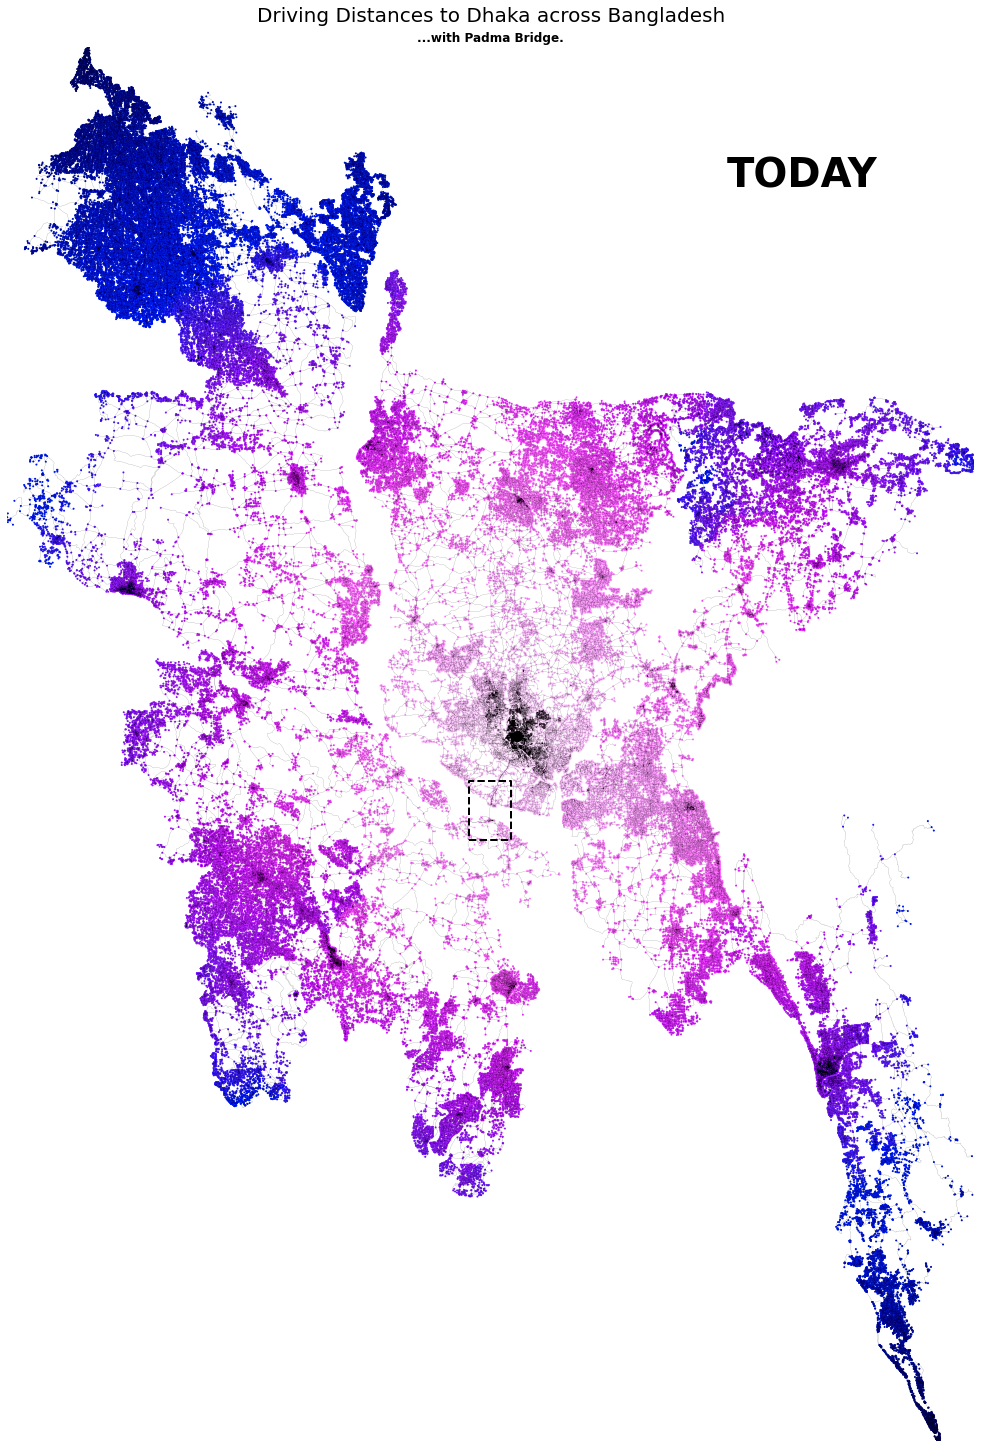

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20), 
                       facecolor='w',
                       constrained_layout=True, 
                       subplot_kw=dict(aspect='equal'))

E.plot(color='k', linewidth=0.05, figsize=(20, 20), ax=ax)

N.merge(post_distances, 
        left_on='osmid', 
        right_on='osmid', 
        how='left').to_crs(3857).plot('distance', markersize=1, cmap=col, ax=ax,
                                     vmin=pre_distances.distance.min(),
                                     vmax=pre_distances.distance.max())

aoi_p.boundary.plot(color='k', linestyle='dashed', linewidth=2, ax=ax)

N[N.index==dhaka].plot(color='k', markersize=1000, ax=ax)

ax.text(0.9, 0.9,
        "TODAY",
        color="k",
        weight='bold',
        fontsize=40,
        ha="right",
        transform=ax.transAxes,
       )

ax.set_xlim((N.geometry.x.min(), N.geometry.x.max()))
ax.set_ylim((N.geometry.y.min(), N.geometry.y.max()))

ax.set_title("...with Padma Bridge.", color='k', weight='bold')

ax.set_axis_off()

fig.suptitle("Driving Distances to Dhaka across Bangladesh", fontsize=20, color='k')
fig.savefig('./scenarios/bangladesh-3.png', facecolor=fig.get_facecolor(), dpi=300, bbox_inches='tight')

In [46]:
import imageio, os
imgs = os.listdir("./scenarios/")
imgs.sort()
imgs = [imageio.imread(f"./scenarios/{x}") for x in imgs] 
imageio.mimsave("../viz/scenarios.gif", imgs, fps=0.5);